In [1]:
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class TrainDataset(Dataset): 
    def __init__(self,path2img,direction='b2a',transform=False):
        super().__init__()
        self.direction=direction
        self.path2a='./facades/train/a'
        self.path2b='./facades/train/b'
        self.img_filenames=[x for x in listdir(self.path2a)]
        self.transform=transform
    def __len__(self):
        return len(self.img_filenames)
    def __getitem__(self, idx): 
        a=Image.open(self.path2a+'/'+self.img_filenames[idx])
        b=Image.open(self.path2b+'/'+self.img_filenames[idx])

        if self.transform:
            a=self.transform(a)
            b=self.transform(b)

        if self.direction=='b2a':
            return b,a
        else:
            return a,b

In [3]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                              transforms.Resize((256,256))
                              ])


In [4]:
path2img='./facades/train'
train_Dataset=TrainDataset(path2img=path2img,transform=transform)
train_Dataloader = DataLoader(train_Dataset, batch_size=32, shuffle=True)

c:\Users\user\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(-0.5, 255.5, 255.5, -0.5)

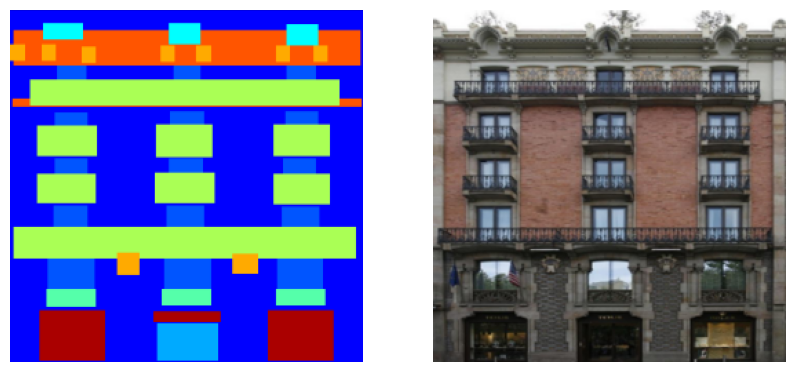

In [5]:
a,b = train_Dataset[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

In [6]:
class UnetDown(nn.Module):
    def __init__(self,in_channels,out_channels,normalize=True,dropout=0.0):
        super().__init__()
        layers=[nn.Conv2d(in_channels,out_channels,4,stride=2,padding=1,bias=False)]
        
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))
        
        self.down=nn.Sequential(*layers)

    def forward(self,x):
        x=self.down(x)
        return x

In [7]:
class UnetUp(nn.Module):
    def __init__(self,in_channels,out_channels,dropout=0.0):
        super().__init__()
        layers=[nn.ConvTranspose2d(in_channels,out_channels,4,stride=2,padding=1,bias=False),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU()
                ]

        if dropout:
            layers.append(nn.Dropout(dropout))
        
        self.up=nn.Sequential(*layers)

    def forward(self,x,skip):
        x=self.up(x)
        x=torch.cat((x,skip),1) #tensor combine
        return x

In [10]:
# check
x = torch.randn(16, 128, 64, 64, device=device)
model = UnetUp(128,64).to(device)
out = model(x,down_out)
print(out.shape)

NameError: name 'down_out' is not defined

In [11]:
class GenUnet(nn.Module):
    def __init__(self,in_channels=3,out_channels=3):                #self,RGB->3,RGB->3
        super().__init__()

        self.down1=UnetDown(in_channels,64,normalize=False) 
        self.down2=UnetDown(64,128)
        self.down3=UnetDown(128,256)
        self.down4=UnetDown(256,512,dropout=0.5)
        self.down5=UnetDown(512,512,dropout=0.5)
        self.down6=UnetDown(512,512,dropout=0.5)
        self.down7=UnetDown(512,512,dropout=0.5)
        self.down8=UnetDown(512,512,normalize=False,dropout=0.5)

        self.up1=UnetUp(512,512,dropout=0.5)
        self.up2=UnetUp(1024,512,dropout=0.5)
        self.up3=UnetUp(1024,512,dropout=0.5)
        self.up4=UnetUp(1024,512,dropout=0.5)
        self.up5=UnetUp(1024,256)
        self.up6=UnetUp(512,128)
        self.up7=UnetUp(256,64)
        self.up8=nn.Sequential(
            nn.ConvTranspose2d(128,3,4,stride=2,padding=1),
            nn.Tanh() #{exp(x)-exp(-x)}/{exp(x)+exp(-x)}
        )

    def forward(self,x):
        d1=self.down1(x)
        d2=self.down2(d1)
        d3=self.down3(d2)
        d4=self.down4(d3)
        d5=self.down5(d4)
        d6=self.down6(d5)
        d7=self.down7(d6)
        d8=self.down8(d7)

        u1=self.up1(d8,d7)
        u2=self.up2(u1,d6)
        u3=self.up3(u2,d5)
        u4=self.up4(u3,d4)
        u5=self.up5(u4,d3)
        u6=self.up6(u5,d2)
        u7=self.up7(u6,d1)
        u8=self.up8(u7)

        return u8

In [12]:
class Dis_block(nn.Module):
    def __init__(self,in_channels,out_channels,normalize=True):
        super().__init__()

        layers=[
            nn.Conv2d(in_channels,out_channels,3,stride=2,padding=1)
                ]
        
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))

        layers.append(nn.LeakyReLU(0.2))

        self.block=nn.Sequential(*layers)

    def forward(self,x):
        x=self.block(x)
        return x
    

In [13]:
class Discriminator(nn.Module):
    def __init__(self,in_channels=3):
        super().__init__()

        self.st1=Dis_block(in_channels*2,64,normalize=False)
        self.st2=Dis_block(64,128)
        self.st3=Dis_block(128,256)
        self.st4=Dis_block(256,512)

        self.patch=nn.Conv2d(512,1,3,padding=1) #gen 16x16 patch

    def forward(self,a,b):
        x=torch.cat((a,b),1)
        x=self.st1(x)
        x=self.st2(x)
        x=self.st3(x)
        x=self.st4(x)
        x=self.patch(x)
        x=torch.sigmoid(x)
        return x

In [14]:
model_gen = GenUnet().to(device)
model_dis = Discriminator().to(device)

In [15]:
def init_weight(module):
    class_name = module.__class__.__name__

    if class_name.find("Conv") != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)

model_gen.apply(init_weight)
model_dis.apply(init_weight)

Discriminator(
  (st1): Dis_block(
    (block): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (st2): Dis_block(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (st3): Dis_block(
    (block): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (st4): Dis_block(
    (block): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  

In [16]:
patch=(1,256//2**4,256//2**4)
loss_func_gan=nn.BCELoss()
loss_func_L1=nn.L1Loss()

lambda_pix=100
lr=2e-4
beta1=0.5
beta2=0.999


opt_gen=torch.optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,beta2))
opt_dis=torch.optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,beta2))

In [17]:
model_gen.train()
model_dis.train()

batch_count=0
epoch=100
start_time=time.time()

loss_hist = {'gen':[],
             'dis':[]}

In [18]:
for i in range(epoch):
    for a,b in train_Dataloader:
        ba_si=a.size(0) #0:aixs

        real_a=a.to(device)
        real_b=b.to(device)


        real_label=torch.ones(ba_si,*patch,requires_grad=False).to(device)
        fake_label=torch.zeros(ba_si,*patch,requires_grad=False).to(device)

        #########################################################################
        #generator
        model_gen.zero_grad()

        out_dis=model_dis(real_b,real_a)

        fake_b=model_gen(real_a) #gen fake image
        out_dis=model_dis(fake_b,real_b) #discriminate fake image

        gen_loss=loss_func_gan(out_dis,real_label)
        pixel_loss=loss_func_L1(fake_b,real_b)

        ########################################
        gen_loss=gen_loss+lambda_pix*pixel_loss #pix2pix paper final object
        ########################################

        gen_loss.backward()
        opt_gen.step()

        #discriminator
        model_dis.zero_grad()

        out_dis=model_dis(real_b,real_a)
        real_loss=loss_func_gan(out_dis,real_label)

        out_dis=model_dis(fake_b.detach(),real_a)
        fake_loss=loss_func_gan(out_dis,fake_label)

        d_loss=(real_loss+fake_loss)/2
        d_loss.backward()
        opt_dis.step()

        loss_hist['gen'].append(gen_loss.item())
        loss_hist['dis'].append(d_loss.item())


        batch_count += 1

        #train info
        if batch_count % 100 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(i, gen_loss.item(), d_loss.item(), (time.time()-start_time)/60))


Epoch: 7, G_Loss: 33.301258, D_Loss: 0.032774, time: 0.80 min
Epoch: 15, G_Loss: 29.668167, D_Loss: 0.048718, time: 1.50 min
Epoch: 23, G_Loss: 27.496004, D_Loss: 0.012607, time: 2.22 min
Epoch: 30, G_Loss: 27.178606, D_Loss: 0.011995, time: 2.91 min
Epoch: 38, G_Loss: 24.013321, D_Loss: 0.024608, time: 3.59 min
Epoch: 46, G_Loss: 24.346783, D_Loss: 0.008987, time: 4.26 min
Epoch: 53, G_Loss: 22.999847, D_Loss: 0.006883, time: 4.94 min
Epoch: 61, G_Loss: 22.541338, D_Loss: 0.005829, time: 5.62 min
Epoch: 69, G_Loss: 21.351419, D_Loss: 0.003589, time: 6.29 min
Epoch: 76, G_Loss: 19.607763, D_Loss: 0.003062, time: 6.97 min
Epoch: 84, G_Loss: 18.660677, D_Loss: 0.002489, time: 7.66 min
Epoch: 92, G_Loss: 20.164988, D_Loss: 0.001870, time: 8.36 min
Epoch: 99, G_Loss: 18.845497, D_Loss: 0.001840, time: 9.10 min


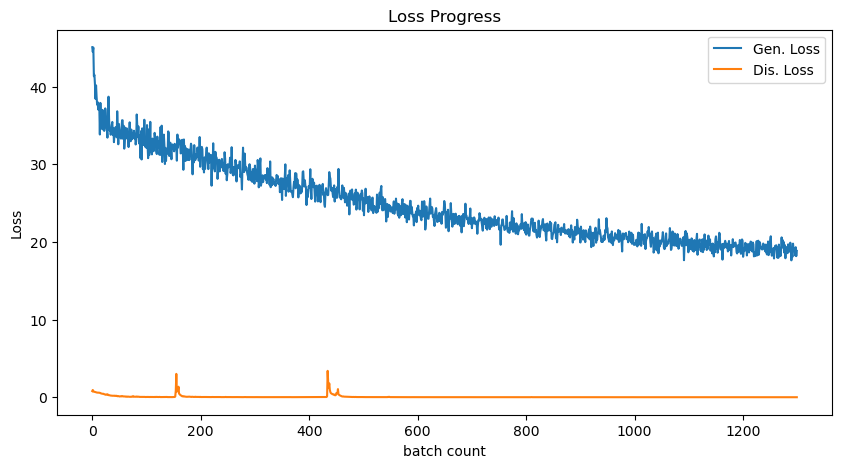

In [19]:
# loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# 가중치 저장
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [21]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

<All keys matched successfully>

In [25]:
# evaluation model
model_gen.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in train_Dataloader:
        origin_imgs=a
        fake_imgs = model_gen(a.to(device)).detach().cpu()
        real_imgs = b
        break

c:\Users\user\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


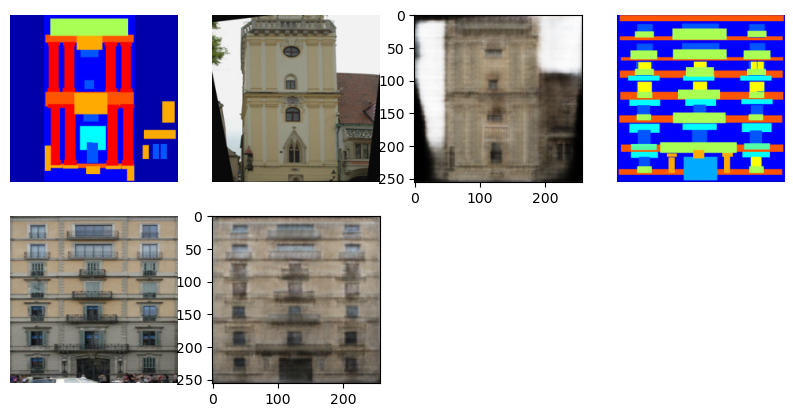

In [36]:
# 가짜 이미지 시각화
plt.figure(figsize=(10,10))

for ii in range(0,4,3):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*origin_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(4,4,ii+2)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(4,4,ii+3)
    plt.imshow(to_pil_image(0.5*fake_imgs[ii]+0.5))
    plt.axis('on')